# Kappa Architecture

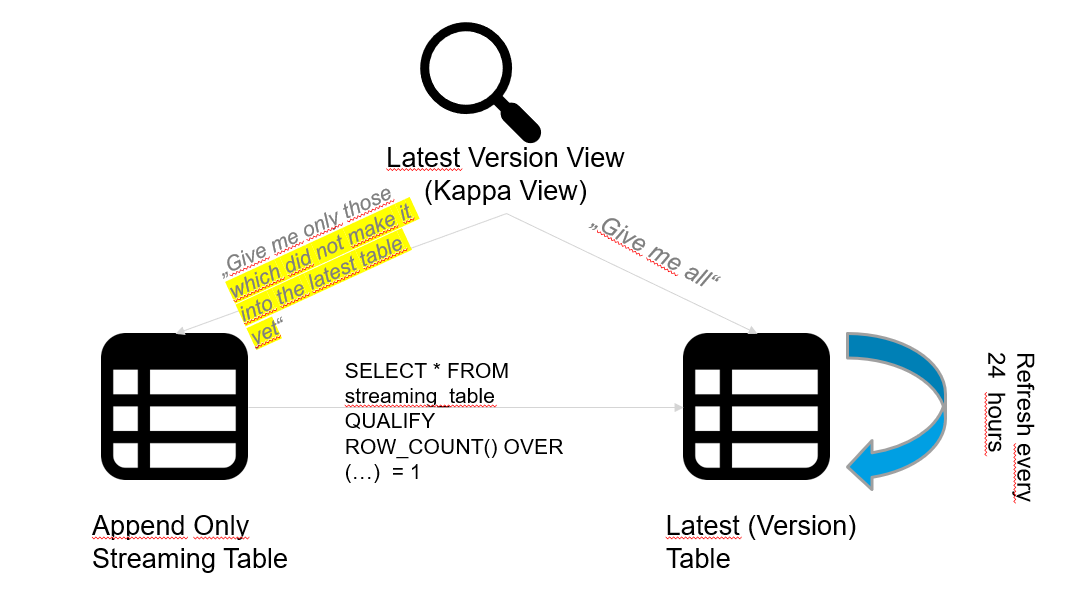

This notebook illustrates how to setup a Kappa Architecture for streaming tables.

For this demo, we will use a (very simple) customer object. We will generate the required tables and views and generate sample data. The customer structure we are going to use looks as follows: 

```JSON
 { "customer_id":  str(uuid.uuid4())
           , "first_name": names.get_first_name(gender=gender)
           , "last_name": names.get_last_name()
           , "birthdate": datetime.date(random.randint(1900,2021),random.randint(1,12),random.randint(1,12)).isoformat()
           , "gender": str(gender)
           , "business_event_ts": rnd_ts[0].isoformat()
            , "ingest_ts": rnd_ts[1].isoformat()
 }   
```

customer_id is our key which helps us with identifying customers uniquely. Multiple records sharing the same customer_id are considered being updates. 

You can change the default naming options in the first cell in the table_names dictionary:
* streaming_table: The table into which the data is ingested into in a near-realtime append only manner
* latest_version_view: Name of the view that calculates the latest version for each entity based on the streaming table
* latest_table: Table that only contains the latest version per entity
* kappa_view: Kappa view: Gives you back the same results as the latest_version_view (only the latest version using all available data, not only what has been ingested to the latest table already) in an efficient manner. Hopefully consumes little data than the latest_version_view for doing so (quot est demonstrandum)

In [1]:
# Some initial setup ...
%pip install multiprocess  # need to use multiprocess instead of builtin multiprocessing due to running in an interactive shell
%pip install ipython-bg
%load_ext ipython_bg

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime
from google.cloud import bigquery

bq = bigquery.Client(location="EU")   # MMS will not use other then EU locations - change accordingly
dataset_name = "demo_kappa_architecture_final_2"  # BQ dataset name
dataset_default_table_expiration_ms = 24 * 60 * 60 * 1000 # Tables in this dataset will expire after this amount of ms (24h)

table_names = { "streaming_table": "customers_stream"   # Table names for streaming & latest table and kappa view
               , "latest_table": "customers_latest"
               , "kappa_view": "v_customers_latest" 
               , "latest_version_view": "v_customers_streaming_latest"
              }

target_tables = [f"{dataset_name}.{table_names['streaming_table']}"]

# Create dataset and configure expiration of tables
dataset_ref = bq.dataset(dataset_name)    
dataset = bq.create_dataset(dataset_ref,exists_ok=True)
dataset.default_table_expiration_ms = dataset_default_table_expiration_ms

dataset = bq.update_dataset(
    dataset, ["default_table_expiration_ms"]
) 



In [3]:
def create_streaming_table():
    """
    Creates our base table into which we stream our customer data
    """
    partitioned_by_day = f"""
    CREATE  TABLE IF NOT EXISTS {dataset_name}.{table_names['streaming_table']}
    ( customer_id String
     , first_name String
     , last_name String
     , gender String 
     , birthdate Date
     , business_event_ts Timestamp
     , ingest_ts Timestamp
     )
     PARTITION BY TIMESTAMP_TRUNC(ingest_ts,DAY)
     CLUSTER BY business_event_ts    # without clustering, it's not going to work
    """
    
    bq.query(partitioned_by_day).result()


In [4]:
# Generating sample data

import random,uuid
from enum import Enum
import names
from datetime import timedelta

class Gender(Enum):
    FEMALE = 'female'
    MALE = 'male'
    
    def __str__(self):
        return str(self.value)

def get_rnd_ts_pair(max_days_back=15,max_hours_back=24,max_minutes_back=60):
    """
    returns a pair tuple of business_event_ts and ingest_ts which is a few seconds after business_event_ts
    """
    business_event_ts = datetime.datetime.utcnow() - timedelta(days=random.randint(0,max_days_back),hours=random.randint(0,max_hours_back),minutes=random.randint(0,max_minutes_back))
    ingest_ts = business_event_ts + timedelta(seconds=random.randint(10,150))
    
    return (business_event_ts, ingest_ts)

from functools import lru_cache
@lru_cache(maxsize=1)
def get_customer_ids(n=1000):
    """
    Gets us some IDs of already existing customers. Can be used for generating updates to existing customers. The LRU cache annoation prevents the function
    from querying BQ each time, but takes away the sampling feature if called with same argument. Good enough for demo purposes.
    """
    query = f"""SELECT customer_id from {dataset_name}.{table_names['streaming_table']}
             WHERE DATE(ingest_ts) < CURRENT_DATE()
             AND  rand() < 0.1 LIMIT {n} """
    
    result = bq.query(query)
    return result.to_dataframe().iloc[:, 0].to_list()
        
    
def get_random_customer(for_streaming=False,update_rate=0.01,known_customers:list=None):
    """
    Generates us a random customers. If you pass in a list of known customers and set update_rate > 0, the share of update rate percent records will be updates instead of new
    customer ids.
    """
    
    gender = random.choice(list(Gender))

    # For the initial load, we also need to generate older data
    max_days_back = 15            
    max_hours_back = 24
    max_minutes_back = 60
    
    # For simulation of near-realtime streaming, we only create recent data 
    if for_streaming:
        max_days_back = 0
        max_hours_back = 0
        max_minutes_back = 30

    rnd_ts = get_rnd_ts_pair(max_days_back,max_hours_back,max_minutes_back)
    
    customer = { "customer_id":  str(uuid.uuid4())
           , "first_name": names.get_first_name(gender=gender)
           , "last_name": names.get_last_name()
           , "birthdate": datetime.date(random.randint(1900,2021),random.randint(1,12),random.randint(1,12)).isoformat()
           , "gender": str(gender)
           , "business_event_ts": rnd_ts[0].isoformat()
            , "ingest_ts": rnd_ts[1].isoformat()
           }
    
    if known_customers and random.random() < update_rate:
        customer["customer_id"] = random.choice(known_customers)
        
    return customer


from joblib import Parallel, delayed
def get_random_customers(n=1000, jobs=5, **kwargs ):
    """Wrapper that helps us generating a bigger number of customers"""
    return Parallel(n_jobs=jobs)(delayed(get_random_customer)(**kwargs) for i in range(n))



In [5]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def streaming_insert(data,table):
    """
    Does a streaming insert to BQ. Uses the deprecated insert_rows method for simplicity. Use BQ Storage API Write instead!
    """
    
    table = bq.get_table(table)
    errors = bq.insert_rows(table,data)
    return errors

def multiply_records_in_table(table,factor=1):
    """Multiplies records in the table by just copying it factor number of times"""
    
    sql = f"""
    INSERT INTO {dataset_name}.{table}
    with records AS (
     SELECT * FROM {dataset_name}.{table}
     )
    , multiplier as (
      SELECT 1 from {dataset_name}.INFORMATION_SCHEMA.PARTITIONS LIMIT {factor}
      )
    SELECT r.* FROM records r CROSS JOIN multiplier
    
    """
    bq.query(sql).result()
    



import io,json
def batch_load_table_from_json(js,table):
    """ Does a batch (?) load from generated JSON"""
    
    table = bq.get_table(table)
    bq.load_table_from_json(json_rows=js,destination=table)
    

def do_initial_load(*tables,n_records=100_000,update_rate=0.01):
    """
    Performs an initial load of sample data. As generating huge amount of data can be slow, it generates some data and than simply multiplies it
    """
    known_customers = []
    
    if update_rate > 0:
        known_customers = get_customer_ids(int(n_records*update_rate))
    
    if len(known_customers) == 0 and update_rate > 0:
        print("Tables are still empty. No known customers, hence no updates.")
        update_rate = 0
        
    max_records_in_ram = 100_000
    num_chunks = math.ceil(n_records/max_records_in_ram)

    for i in range(num_chunks):
        print(f"Initial Load of chunk {i} of size {max_records_in_ram} to target_tables {tables}")
        data = get_random_customers(n_records,for_streaming=False,update_rate=update_rate,known_customers=known_customers)
        for table in tables:
            batch_load_table_from_json(data,table)   # This is not blocking
    

import math

def stream_into_tables(*tables, n_records=1_000_000,update_rate=0.01):
    """streams up to n_records into the target table(s)"""
    if update_rate > 0:
        known_customers = get_customer_ids(int(n_records*update_rate))
    max_batch_size = 100
    num_chunks = math.ceil(n_records/max_batch_size)
    print(tables)
    
    for _ in range(num_chunks):
        data = get_random_customers(max_batch_size,for_streaming=True,update_rate=update_rate,known_customers=known_customers)
        
        errors = Parallel(n_jobs=len(tables),require="sharedmem")(delayed(streaming_insert)(data,table) for table in tables )
        print(errors)
        print(f"Wrote batch of {max_batch_size} to tables {tables}") 

import multiprocess
from multiprocess import Pool  
from functools import partial


stream_to_table = partial(stream_into_tables, *target_tables, n_records=100_000,update_rate=0.55)




In [6]:
def refresh_latest_table():
    """
    Refreshes the latest version table by recreating it. Handily it can also be used for generating the table for initially generating the table.
    """
    refresh_latest_table =f"""
    CREATE OR REPLACE TABLE {dataset_name}.{table_names['latest_table']}
    PARTITION BY DATE(ingest_ts)
    AS
    SELECT * FROM {dataset_name}.{table_names['streaming_table']}
    QUALIFY ROW_NUMBER() OVER(PARTITION BY customer_id ORDER BY ingest_ts DESC) = 1
    """
    
    bq.query(refresh_latest_table).result()
    


In [7]:
def create_kappa_view():
    """
    Creates the kappa view
    """
    
    sql = f"""
    CREATE OR REPLACE VIEW {dataset_name}.{table_names['kappa_view']} AS
        
 
    WITH last_refresh_ts AS (
        SELECT MAX(PARSE_DATE("%Y%m%d", partition_id)) as ts
         FROM  {dataset_name}.INFORMATION_SCHEMA.PARTITIONS
         WHERE  1=1
         AND table_name = '{table_names["latest_table"]}'
         AND partition_id <> '__STREAMING_UNPARTITIONED__'
         AND total_rows > 0
         ) ,
   latest_table_data as (
    SELECT *
      FROM {dataset_name}.{table_names['latest_table']}
    ),
    latest_stream_data as (
        SELECT *
          FROM {dataset_name}.{table_names['streaming_table']}
         WHERE DATE(ingest_ts) >= (SELECT ts               -- Uncorrelated Subquery
                               FROM last_refresh_ts)
    )
    , combined_data as (
        SELECT *
         FROM latest_table_data
        UNION ALL
        SELECT *
          FROM latest_stream_data
    )
    SELECT *
      FROM combined_data
    QUALIFY ROW_NUMBER() OVER(PARTITION BY customer_id
                                  ORDER BY ingest_ts DESC)
                         = 1
        """
    bq.query(sql).result()



def create_latest_version_view():
    """
    Creates a latest version view (the view that determines the latest version for each entity on the fly based on the streaming table). This is the baseline 
    for our kappa view.
    """
    
    sql = f"""
    CREATE OR REPLACE VIEW {dataset_name}.{table_names['latest_version_view']} AS 
    SELECT * 
    FROM {dataset_name}.{table_names['streaming_table']}
    QUALIFY ROW_NUMBER() OVER(PARTITION BY customer_id ORDER BY ingest_ts DESC) = 1
    """
    
    bq.query(sql).result()
    result = bq.query(sql).to_dataframe()
    display(result)
    return result


def query_latest_version_view():
    """Query the latest version view (just to see how much data it consumes)"""
    
    job_config = bigquery.QueryJobConfig(use_query_cache=False)    # For a fair comparison, do not use cached queries!

    sql = f"""SELECT * FROM {dataset_name}.{table_names['latest_version_view']} """
    job = bq.query(sql,job_config=job_config)
    job.result()
    print(f"Finished querying the latest version view. GB processed: {job.total_bytes_processed/1024**3} GB Billed {job.total_bytes_billed/1024**3}")
    return job.total_bytes_processed, job.total_bytes_billed

 
def query_kappa_view():
    """Query the kappa view (just to see how much data it consumes)"""
    
    job_config = bigquery.QueryJobConfig(use_query_cache=False)    # For a fair comparison, do not use cached queries!
    
    sql = f"""SELECT * FROM {dataset_name}.{table_names['kappa_view']}"""
    job = bq.query(sql,job_config=job_config)
    job.result()
    print(f"Finished querying the kappa view. GB processed: {job.total_bytes_processed/1024**3} GB Billed {job.total_bytes_billed/1024**3}")
    return job.total_bytes_processed, job.total_bytes_billed

def get_max_ingest_ts(table_name,ingest_ts_col_name="ingest_ts"):
    """Queries the max ingest_ts of the table"""
    sql = f""" SELECT MAX(INGEST_TS) as max_ts
                FROM {table_name}
           """
    job = bq.query(sql)
    return list(job.result())[0]["max_ts"]
    

def get_dead_weight(table,pk_col="customer_id", order_col="ingest_ts"):
    """
    Gets the 'dead weight' of a table (this is, it helps you calculating the ratio of current vs. history records. We consider history records dead weight.
    """
    sql = f"""
    WITH versions as 
    (SELECT  ROW_NUMBER() OVER (PARTITION BY {pk_col} ORDER BY {order_col}  DESC) = 1 AS is_latest_version_flag
    FROM {table}
    )
    , agg as (
    SELECT is_latest_version_flag, COUNT(*) as cnt
    FROM versions
    GROUP BY 1
    )
    SELECT * from agg
    """
    
    display(bq.query(sql).to_dataframe())
    

def get_partitions_for_table(table):
    """
    Gets and displays the partition information for the table from the BQ INFORMATION_SCHEMA
    """
    partitions = f"""
    SELECT * FROM {dataset_name}.INFORMATION_SCHEMA.PARTITIONS
    WHERE table_name = '{table}'
    ORDER BY partition_id
    """

    display(bq.query(partitions).to_dataframe())


## Bulding Kappa
Now let's put all pieces together: 

1. Create the streaming table
2. Create the latest table
3. Build the latest version and kappa view
4. Generate some data
5. Multiply the data to make the table huge

This is going to take some minutes... so grab yourself another coffee.

In [8]:
    
# Now let's put all together

# Create Streaming Table
create_streaming_table()
# Create Latest Table
refresh_latest_table()
# Create Kappa View
create_kappa_view()
# Create Latest Table View
create_latest_version_view()

# Prepare initial load - put 20k records into the table
records_per_load = 1_000
initial_load_records = 100_000
inital_load = partial(do_initial_load, *target_tables, n_records=records_per_load,update_rate=0.45)
num_workers = 10

from multiprocess import Pool
with Pool(num_workers) as pool:
    
   pool_result = pool.starmap(inital_load, [() for _ in range(int(math.ceil(initial_load_records/records_per_load)))])

# Lets multiply the number of records some time in order to make the table real big
multiply_records_in_table(table_names["streaming_table"],factor=10)   # will take us to 1,1 m records
multiply_records_in_table(table_names["streaming_table"],factor=10)  # 11m records
multiply_records_in_table(table_names["streaming_table"],factor=10)  # 110m records
multiply_records_in_table(table_names["streaming_table"],factor=5)  # 550m records

#refresh the latest table after the initial load of the streaming table
refresh_latest_table()

""


Tables are still empty. No known customers, hence no updates.
Initial Load of chunk 0 of size 100000 to target_tables ('demo_kappa_architecture_final_2.customers_stream',)
Tables are still empty. No known customers, hence no updates.
Initial Load of chunk 0 of size 100000 to target_tables ('demo_kappa_architecture_final_2.customers_stream',)
Tables are still empty. No known customers, hence no updates.
Initial Load of chunk 0 of size 100000 to target_tables ('demo_kappa_architecture_final_2.customers_stream',)Tables are still empty. No known customers, hence no updates.

Initial Load of chunk 0 of size 100000 to target_tables ('demo_kappa_architecture_final_2.customers_stream',)
Tables are still empty. No known customers, hence no updates.
Initial Load of chunk 0 of size 100000 to target_tables ('demo_kappa_architecture_final_2.customers_stream',)
Tables are still empty. No known customers, hence no updates.Tables are still empty. No known customers, hence no updates.
Initial Load of c

## Let the games begin
Now that we have set everything up and our streaming table is populated, let the games begin... 

The initial load was to simulate some historic load of the table. Now let's start the streaming in order to simulate near-realtime provision of data. All the data that we insert from now on will not make it into the latest table (until we call refresh_latest_table method one more time). Contrary to the latest table, querying the kappa view will also return this brand-new data. 

The streaming runs in the background, so we can go on with our analysis in the meantime. 

In [9]:
%%bg     # Need to use https://pypi.org/project/ipython-bg/  here - starmap_async is not working in jupyter notebooks

def start_stream_in_background(num_workers=1):
    """
    Stars a multiprocessing pool with n workers that all stream data into the table
    """
    with Pool(num_workers) as pool:
        # the map method takes a function / callable as first argument and a iterable which carries the argument for the callble as second. It chops the iterable into chunks, which it submits to the process pool. 
        # This works only for one-argumented function calls. For more arguments, you can use starmap-function instead. 
        # Note that this method is blocking - it returns only when all work items are finished. 
        # map_async instead is non-blocking and works with callbacks and AyncResult-Objects
        results = pool.starmap(stream_to_table, [() for _ in range(10)])

    
start_stream_in_background(5)

[1] running in background
('demo_kappa_architecture_final_2.customers_stream',)
('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.custom

## Examine the streaming table

First let's have a look at the dead weight of the streaming table. The dead weight with respect to queries that care only about the latest version of an entity is the number of history versions in the table. When querying the table for all latest versions, these history versions are also read from the table and hence will be billed even though none of these records will make it into the result set. This is why for latest version queries, we consider these records as dead weight.

Due to the way how we populated the table - by only generating a limited number of random records and multiplying it multiple times - we get a very bad ratio of latest versions to history versions (i.e. a high dead weight). This is a theoretical example. In real world, the dead weight of your streaming table depends on a number of factors like

* Age / Lifetime of the table
* Rate of updates per entity

Most likely, you will never see such a heavy dead weight like here. This demo environment is made up for the kappa architecture and it can really shine here. Benefits in real world will not be that huge.


In [10]:
# Let's have a look at the dead weight
get_dead_weight(*target_tables)

('demo_kappa_architecture_final_2.customers_stream',)
('demo_kappa_architecture_final_2.customers_stream',)
('demo_kappa_architecture_final_2.customers_stream',)


,is_latest_version_flag,cnt
0,True,100000
1,False,776720000


[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to tables ('demo_kappa_architecture_final_2.customers_stream',)
[[]]
Wrote batch of 100 to table

## Run the queries and compare
Let's wait some minutes until the streaming processes inserted some records. Then let's see if the kappa view returns not only the already materialized data from latest table, but also those records that have lately been inserted to the streaming table by the streaming process running in background. Then let's query both the latest record view and the kappa view and compare the data processed / query costs. 

In [12]:
import time
from datetime import timezone

waiting_sec = 60 * 5   # 5 minutes
time.sleep(waiting_sec)

# Lets check the max ingest_ts from kappa view as indicator whether kappa view also returns the latest streaming data
max_ingest_ts = get_max_ingest_ts(target_tables[0])
print(f"Max ingest_ts in kappa view: {max_ingest_ts}")
assert (datetime.datetime.now(timezone.utc) - max_ingest_ts) < datetime.timedelta(minutes=3)

latest_view_data = query_latest_version_view()
kappa_view_data = query_kappa_view()
print()
print()
print(f"Kappa view consumes {kappa_view_data[0]/latest_view_data[0] * 100} % of the data that the latest view consumes. Quot erat demonstrandum!")
print()
print("But let's be honest here. We need to mention that due to our data multiplication strategy the streaming table has a very bad latest to history version ratio. \
You are not going to find anything comparable in real world. But also when your streaming table has less dead weight, you will be able to benefit from kappa architecture!")




Max ingest_ts in kappa view: 2022-11-25 15:13:48.533481+00:00
Finished querying the latest version view. GB processed: 61.57040339335799 GB Billed 61.5712890625
Finished querying the kappa view. GB processed: 2.3357381355017424 GB Billed 2.3359375


Kappa view consumes 3.793605379810966 % of the data that the latest view consumes. Quot erat demonstrandum!

But let's be honest here. We need to mention that due to our data multiplication strategy the streaming table has a very bad latest to history version ratio. You are not going to find anything comparable in real world. But also when your streaming table has less dead weight, you will be able to benefit from kappa architecture!
